# **Clustering de pays asiatiques sur la gestion de la pand√©mie de COVID 19**

In [5]:
# Chargement des principales librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')

## **A propos du jeu de donn√©es** :

Le jeu de donn√©es collect√© sur https://www.worldometers.info/coronavirus/#countries contient des statistiques pays par pays sur la pand√©mie du Covid et inclut les variables suivantes :

| Variable                | Description                                                  |
|-------------------------|--------------------------------------------------------------|
| **ID**                  | Identifiant unique                                           |
| **Country**             | Nom du pays                                                  |
| **TotalCases**          | Nombre total de cas enregistr√©s au moment de la collecte     |
| **TotalDeaths**         | Nombre total de d√©c√®s enregistr√©s au moment de la collecte   |
| **TotalRecovered**      | Nombre de personnes gu√©ries                                 |
| **ActiveCases**         | Nombre de personnes atteintes du virus au moment de la collecte |
| **TotalCasesPerMillion**| Nombre de cas enregistr√©s par million d‚Äôhabitants            |
| **TotalDeathsPerMillion**| Nombre de d√©c√®s enregistr√©s par million d‚Äôhabitants         |
| **TotalTests**          | Nombre total de tests COVID-19 effectu√©s (RTPCR + RAT + autres tests) |
| **TotalTestsPerMillion**| Nombre de tests effectu√©s par million d‚Äôhabitants            |
| **TotalPopulation**     | Population totale du pays                                    |


## **0. Importation de la base**

In [6]:
data = pd.read_csv("../data/CovidCases.csv", sep = ";", index_col = "ID" )
data.head()

Country  TotalCases  TotalDeaths  TotalRecovered  ActiveCases  \
ID                                                                     
1        Yemen        9369       1778.0            5921         1670   
2      Vietnam      839662      20555.0          782199        36908   
3   Uzbekistan      178637       1271.0          174213         3153   
4          UAE      737890       2114.0          731295         4481   
5       Turkey     7444552      66180.0         6893476       484896   

    TotalCasesPerMillion  TotalDeathsPerMillion  TotalTests  \
ID                                                            
1                    306                   58.0    265253.0   
2                   8529                  209.0  42517091.0   
3                   5241                   37.0   1377915.0   
4                  73477                  211.0  87246490.0   
5                  87077                  774.0  89847975.0   

    TotalTestsPerMillion  TotalPopulation  
ID                                         
1                 8651.0         30660443  
2               431850.0         98453377  
3                40425.0         34086135  
4              8687776.0         10042442  
5              1050928.0         85493959

In [7]:
data.shape

(49, 10)

La base de donn√©es comprend 49 observations et 9 variables quantitatives et une variable qualitative (Country). 

## **1. Exploration du jeu de donn√©es**


### **1.1. Gestion des valeurs manquantes**

In [8]:
data.isna().sum()

Country                  0
TotalCases               0
TotalDeaths              1
TotalRecovered           0
ActiveCases              0
TotalCasesPerMillion     0
TotalDeathsPerMillion    1
TotalTests               1
TotalTestsPerMillion     1
TotalPopulation          0
dtype: int64

In [9]:
data.loc[(data.loc[:, ["TotalTestsPerMillion", "TotalDeathsPerMillion"]].isna()).any(axis=1), ["Country", "TotalTests", "TotalTestsPerMillion", "TotalDeaths", "TotalDeathsPerMillion"]]

Country  TotalTests  TotalTestsPerMillion  TotalDeaths  \
ID                                                              
8   Tajikistan         NaN                   NaN        124.0   
25       Macao      4951.0                7495.0          NaN   

    TotalDeathsPerMillion  
ID                         
8                    13.0  
25                    NaN

On note quatre valeurs manquantes dans la base de donn√©es correspondant √† deux pays que nous allons imputer. 

**Les variables TotalTestsPerMillion et TotalTests**

Pour imputer les valeurs manquantes de ces variables, notre intuition a √©t√© d‚Äô√©tablir un lien entre le nombre de tests que r√©alise un pays et sa population en calculant un taux moyen de d√©pistage pour l‚Äôensemble des pays. 

$$
\text{Taux moyen de d√©pistage} = \text{Moyenne}\left(\frac{\text{TotalTests}}{\text{TotalPopulation}}\right)
$$

Ce taux moyen sera ensuite utilis√© pour imputer les valeurs manquantes du Tadjikistan.  

In [10]:
# Calcul du taux moyen de d√©pistage
mean_test_ratio = (data["TotalTests"] / data["TotalPopulation"]).mean()

# imputation
tajikistan_population = data.loc[data["Country"] == "Tajikistan", "TotalPopulation"]
data.loc[data["Country"] == "Tajikistan", "TotalTests"] = tajikistan_population * mean_test_ratio

data.loc[data["Country"] == "Tajikistan", "TotalTestsPerMillion"] = (data.loc[data["Country"] == "Tajikistan", "TotalTests"] * 10**6) / tajikistan_population


**Les variables TotalDeathsPerMillion et TotalDeaths**

En observant la base de donn√©es, on peut facilement soup√ßonner que : 
$$
\text{TotalCases} = \text{ActiveCases} + \text{TotalRecovered} + \text{TotalDeaths}
$$

Nous allons v√©rifier cela. 

In [11]:
Cas = data["TotalDeaths"] +data["TotalRecovered"] +data["ActiveCases"]
diff = data["TotalCases"] - Cas
print(np.sum(diff != 0))   # il s'agit des NA

1


Relation v√©rifi√©e ! On utilise donc cette relation pour imputer les valeurs de ces variables. 

In [12]:
data.loc[data["TotalDeaths"].isna(), "TotalDeaths"] = (data["TotalCases"] - (data["TotalRecovered"] + data["ActiveCases"]))
data.loc[data["TotalDeathsPerMillion"].isna(), "TotalDeathsPerMillion"] = (data["TotalDeaths"] * 10**6 / data["TotalPopulation"])
data.loc[data["Country"] == "Macao", :]

Country  TotalCases  TotalDeaths  TotalRecovered  ActiveCases  \
ID                                                                 
25   Macao          77          0.0              64           13   

    TotalCasesPerMillion  TotalDeathsPerMillion  TotalTests  \
ID                                                            
25                   117                    0.0      4951.0   

    TotalTestsPerMillion  TotalPopulation  
ID                                         
25                7495.0           660595

### **1.2. Visualisation des variables TotalDeaths, TotalRecovered, TotalCases et leurs valeurs par millons**

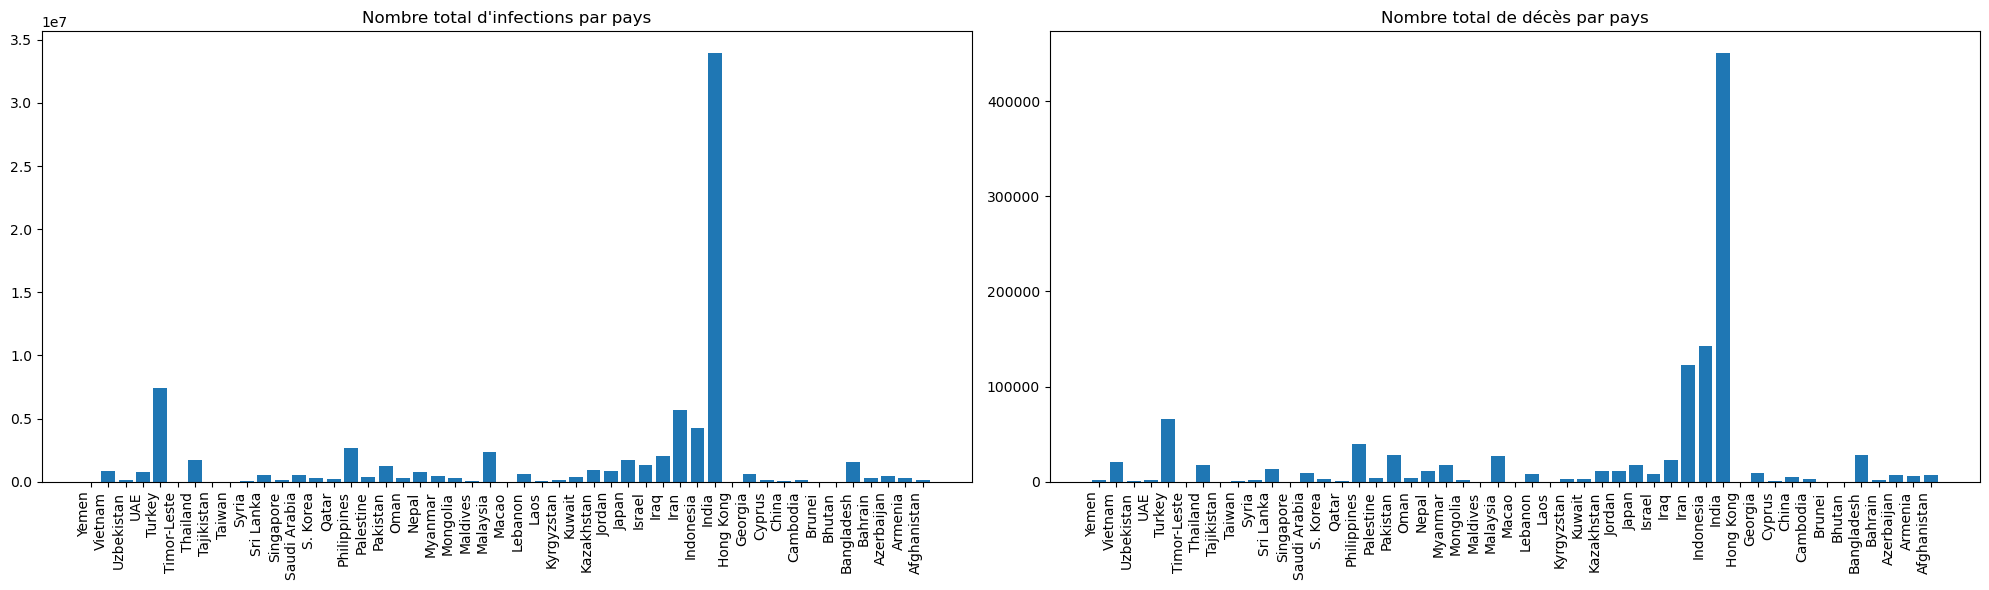

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
plt.bar(data["Country"],data["TotalCases"])
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.title("Nombre total d'infections par pays")

plt.subplot(1,2,2)
plt.bar(data["Country"],data["TotalDeaths"])
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.title("Nombre total de d√©c√®s par pays")
plt.tight_layout()
plt.show()


Les variables TotalCases, TotalDeaths et TotalRecovered ne sont pas directement utilisables car elles
 pourraient nous conduire √† des comparaisons biais√©es entre les pays. En effet, ces variables ne tiennent pas
 compte des diff√©rences d√©mographiques : un pays tr√®s peupl√© aura logiquement un nombre total de cas et
 de d√©c√®s plus √©lev√© qu‚Äôun pays avec une petite population, m√™me si l‚Äôimpact du Covid y est moindre.
 
 C‚Äôest pour cette raison que l‚Äôutilisation des variables ...PerMillons para√Æt plus pertinente. Elles permettent
 de relativiser ces diff√©rentes statistiques par rapport √† la taille de la population du pays consid√©r√©, ce qui
 donne une mesure relative et plus √©quitable de la propagation du virus, des gu√©risons et de la mortalit√©.
 La comparaison entre pays va √™tre possible grace √† ces variables en tenant compte des disparit√©s de
 population.

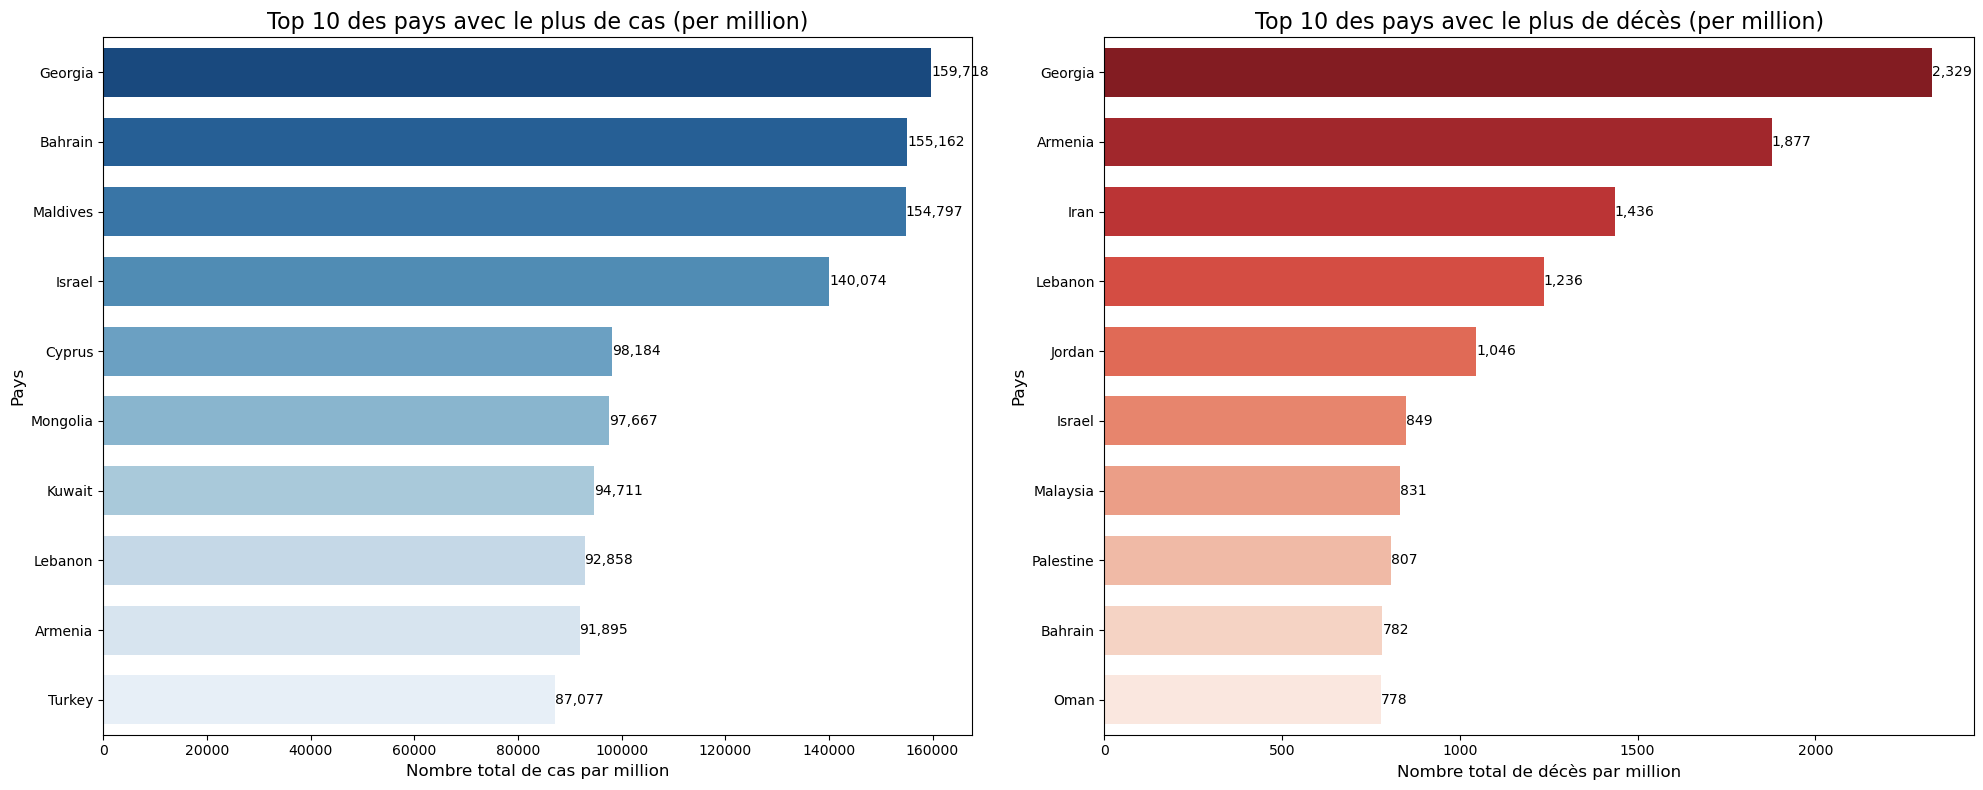

In [ ]:
top_10_cas = data.nlargest(10, "TotalCasesPerMillion")
top_10_deaths = data.nlargest(10, "TotalDeathsPerMillion")

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

colors = sns.color_palette("Blues", len(top_10_cas))
colors_sorted = [colors[i] for i in np.argsort(top_10_cas["TotalCasesPerMillion"])]
ax = sns.barplot(data=top_10_cas, x="TotalCasesPerMillion", y="Country", width=0.7, palette=colors_sorted)
for index, value in enumerate(top_10_cas["TotalCasesPerMillion"]):
    ax.text(value, index, f"{int(value):,}", fontsize=10, color="black", va="center", ha="left")

plt.title("Top 10 des pays avec le plus de cas (per million)", fontsize=16)
plt.xlabel("Nombre total de cas par million", fontsize=12)
plt.ylabel("Pays", fontsize=12)

plt.subplot(1,2,2)

ax = sns.barplot(data=top_10_deaths, x="TotalDeathsPerMillion", y="Country", width=0.7, palette= "Reds_r")

for index, value in enumerate(top_10_deaths["TotalDeathsPerMillion"]):
    ax.text(value, index, f"{int(value):,}", fontsize=10, color="black", va="center", ha="left")

plt.title("Top 10 des pays avec le plus de d√©c√®s (per million)", fontsize=16)
plt.xlabel("Nombre total de d√©c√®s par million", fontsize=12)
plt.ylabel("Pays", fontsize=12)
plt.tight_layout()
plt.show()


- Les pays pr√©sentant les ratios d‚Äôinfection les plus √©lev√©s sont **Georgia**, **Bahrain**, **Maldives** et **Israel**.  
  Cela signifie que proportionnellement √† leur population, ces pays ont enregistr√© un nombre de cas de Covid par million d‚Äôhabitants particuli√®rement √©lev√©. Ces pays ont donc connu une circulation rapide du virus.

- Les pays pr√©sentant les ratios de d√©c√®s les plus √©lev√©s sont **Georgia**, **Armenia**, **Iran** et **Lebanon**.  
  Ces pays se distinguent par un nombre √©lev√© de d√©c√®s rapport√© √† la taille de leur population. Cela peut √™tre li√© √† la qualit√© du syst√®me de sant√© ou encore √† la gestion de la crise du Covid.

On cr√©e une nouvelle variable, le nombre de cas gu√©ris par million d‚Äôhabitants :

$$
\text{TotalRecoveredPerMillion} = \frac{\text{TotalRecovered} \times 10^6}{\text{TotalPopulation}}
$$

In [15]:
data['TotalRecoveredPerMillion'] = (data['TotalRecovered'] * 10**6 / data['TotalPopulation'])

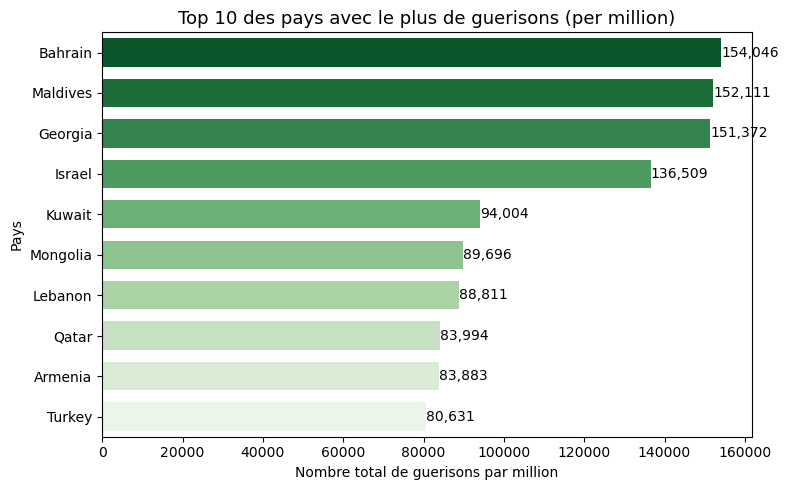

In [ ]:
top_10_recovered = data.nlargest(10, "TotalRecoveredPerMillion")

plt.figure(figsize=(8,5))

colors = sns.color_palette("Greens", len(top_10_cas))
colors_sorted = [colors[i] for i in np.argsort(top_10_recovered["TotalRecoveredPerMillion"])]
ax = sns.barplot(data=top_10_recovered, x="TotalRecoveredPerMillion", y="Country", width=0.7, palette=colors_sorted)
for index, value in enumerate(top_10_recovered["TotalRecoveredPerMillion"]):
    ax.text(value, index, f"{int(value):,}", fontsize=10, color="black", va="center", ha="left")

plt.title("Top 10 des pays avec le plus de guerisons (per million)", fontsize=13)
plt.xlabel("Nombre total de guerisons par million", fontsize=10)
plt.ylabel("Pays", fontsize=10)
plt.tight_layout()
plt.show()

Les pays pr√©sentant les ratios de gu√©rison les plus √©lev√©s sont
 Bahrain, Maldives, Georgia et Israel. Ces
 pays ont un meilleur syst√®me de sant√©.

### **1.3. Pourcentage de mort, de gu√©rison et de cas actives**

Nous calculons ici les pourcentages de l√©talit√© (proportion de d√©c√®s li√©s au Covid par rapport au nombre total de cas atteints par le Covid), de gu√©rison et de cas actifs par rapport au nombre total de cas Covid.

- **Pourcentage de l√©talit√© (Deaths percent)** :

$$
\text{Deaths percent} = \frac{\text{TotalDeaths}}{\text{TotalCases}} \times 100
$$

- **Pourcentage de cas actifs (ActiveCases percent)** :

$$
\text{ActiveCases percent} = \frac{\text{ActiveCases}}{\text{TotalCases}} \times 100
$$

- **Pourcentage de cas gu√©ris (Recovered percent)** :

$$
\text{Recovered percent} = \frac{\text{TotalRecovered}}{\text{TotalCases}} \times 100
$$

Ces taux permettent de comparer plus pr√©cis√©ment l'impact du Covid-19 dans chaque pays, ind√©pendamment du nombre total de cas.


In [17]:
data_mod = data.copy()

In [18]:
data_mod["Deaths_percent"] = (data_mod["TotalDeaths"]/data_mod["TotalCases"])*100
data_mod["ActiveCases_percent"] = (data_mod["ActiveCases"]/data_mod["TotalCases"])*100
data_mod["Recovered_percent"] = (data_mod["TotalRecovered"]/data_mod["TotalCases"])*100

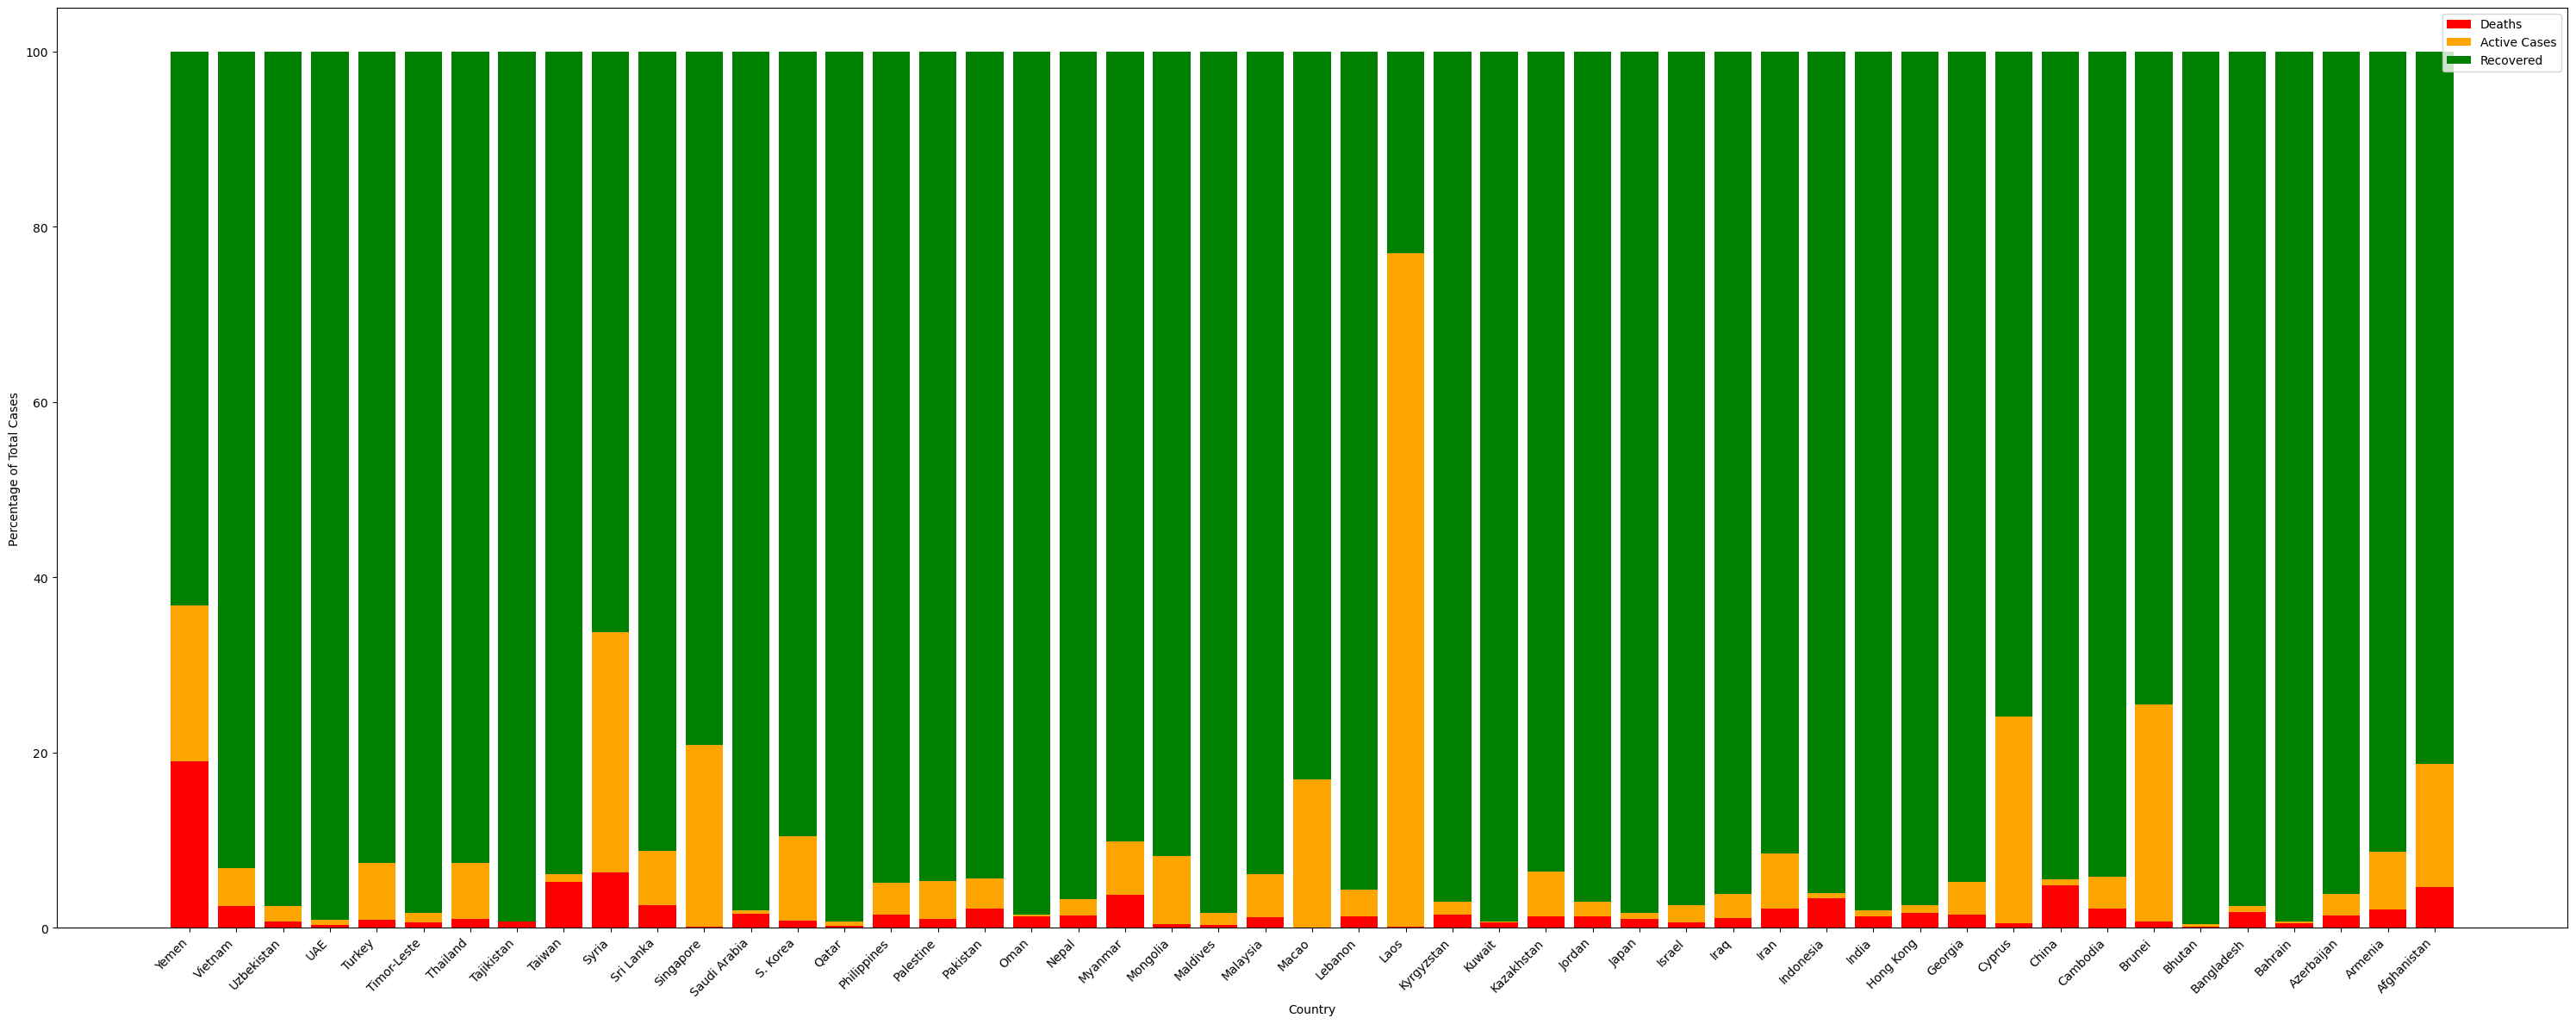

In [ ]:
fig, ax = plt.subplots(figsize=(30, 12))

ax.bar(data_mod['Country'], data_mod['Deaths_percent'], label='Deaths', color='red')
ax.bar(data_mod['Country'], data_mod['ActiveCases_percent'], bottom=data_mod['Deaths_percent'], label='Active Cases', color='orange')
ax.bar(data_mod['Country'], data_mod['Recovered_percent'], bottom=data_mod['Deaths_percent'] + data_mod['ActiveCases_percent'], label='Recovered', color='green')

ax.set_xlabel('Country')
ax.set_ylabel('Percentage of Total Cases')

plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Ce graphique met en √©vidence les d√©c√®s, cas actifs et cas gu√©ris sur le total des cas dans chaque pays.  
On remarque que :

- **Le Laos** a un taux de gu√©rison bien en dessous des autres pays.  
- **Le Y√©men** a le taux de l√©talit√© le plus √©lev√© parmi les autres pays.  


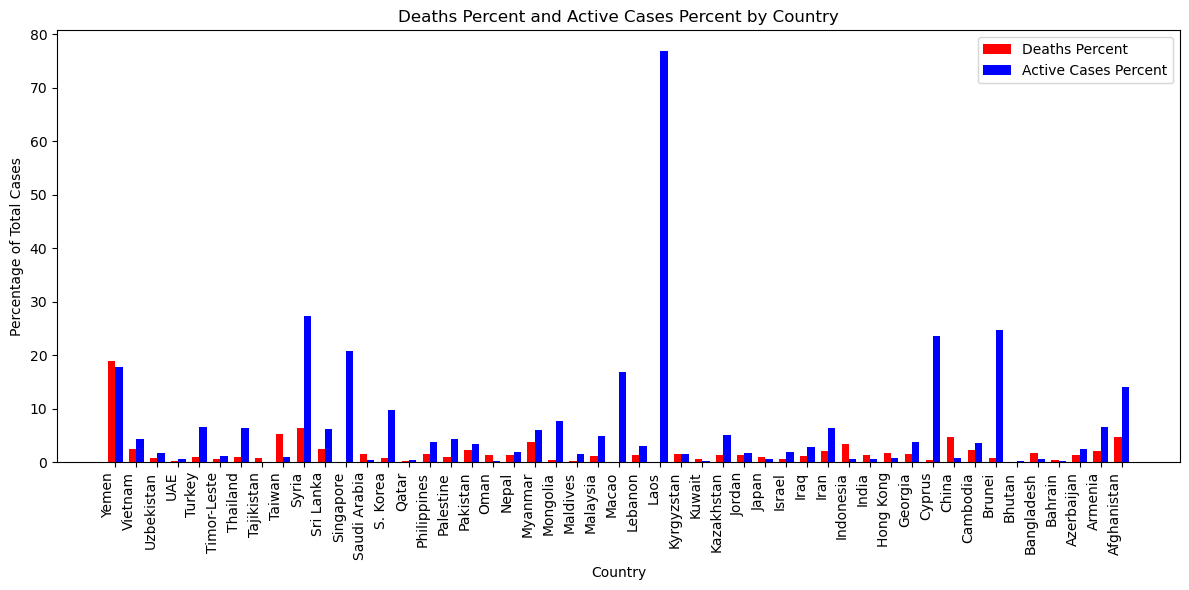

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(data_mod['Country']))
ax.bar(index, data_mod['Deaths_percent'], bar_width, label='Deaths Percent', color='red')
ax.bar(index + bar_width, data_mod['ActiveCases_percent'], bar_width, label='Active Cases Percent', color='blue')

ax.set_xlabel('Country')
ax.set_ylabel('Percentage of Total Cases')
ax.set_title('Deaths Percent and Active Cases Percent by Country')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(data_mod['Country'])

plt.xticks(rotation=90, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

On remarque ici que le Laos est tr√®s largement au dessus des autres pays en termes de pourcentage de
 cas actifs (environ 77%).

### **1.4. Matrice de corr√©lation**


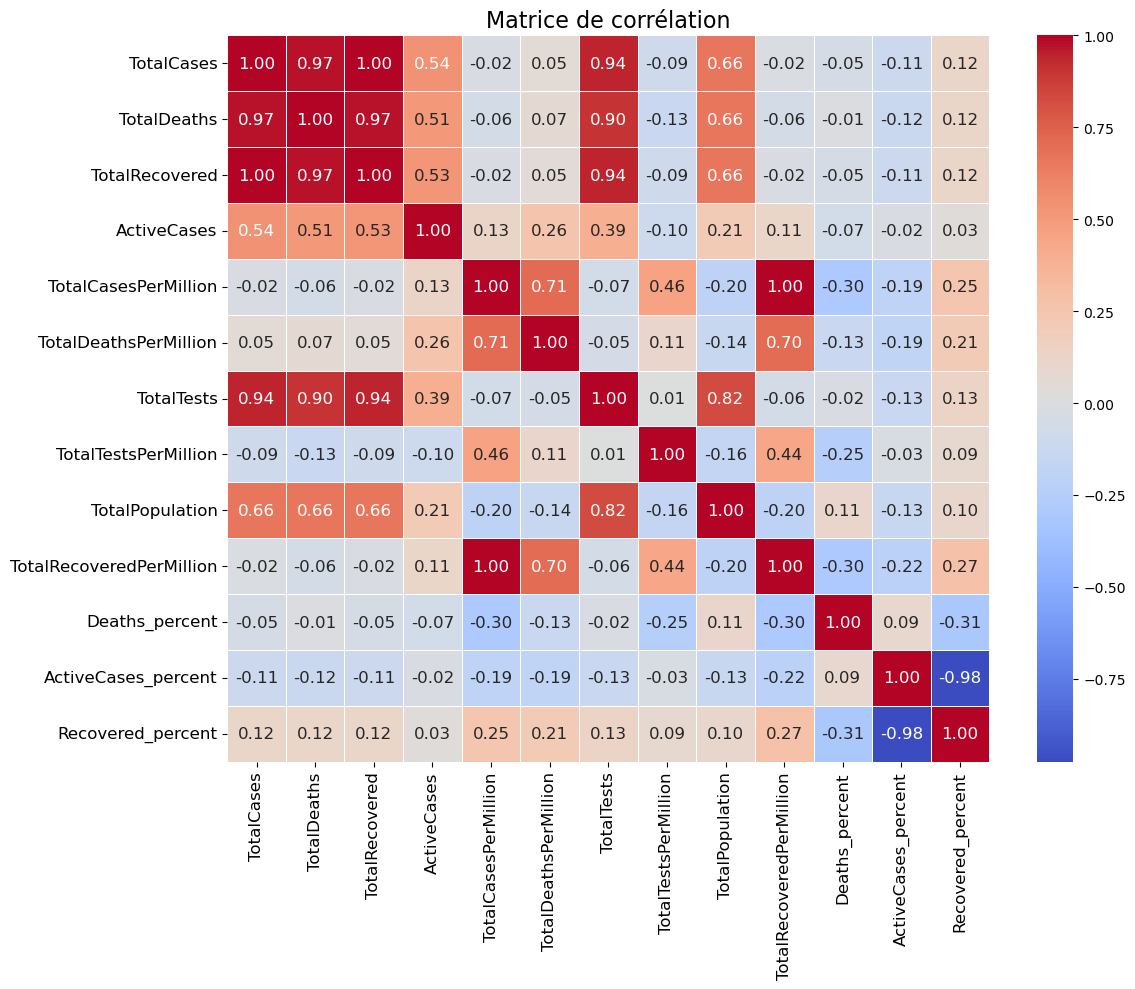

In [ ]:
data1 = data_mod.drop(columns = "Country")
plt.figure(figsize=(12,10))
sns.heatmap(data1.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 12})
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Matrice de corr√©lation",  fontsize = 16)
plt.tight_layout()
plt.show()

La matrice de corr√©lation met en √©vidence des corr√©lations lin√©aires tr√®s fortes entre certaines variables de la base de donn√©es.  
On peut notamment observer que :

- Les variables **TotalCases**, **TotalDeaths** et **TotalRecovered** sont fortement corr√©l√©es deux √† deux.  
- Naturellement, les versions **PerMillion** de ces variables sont √©galement fortement corr√©l√©es entre elles.  
- La variable **TotalTests** est tr√®s li√©e √† chacune des trois variables **TotalCases**, **TotalDeaths** et **TotalRecovered**.  
- **TotalPopulation** est fortement corr√©l√©e √† **TotalCases** et **TotalTests**.  
- Les variables **ActiveCases percent** et **Recovered percent** pr√©sentent une corr√©lation presque parfaite.  


## **2. Mod√©lisation**

Notre probl√©matique, telle que d√©finie, consiste √† r√©soudre un probl√®me de clustering et nous utiliserons ici les kmeans pour ce faire.  

**Comment fonctionne l'algorithme des kmeans ?**

Les K-Means sont bas√©s sur la **minimisation de la variance intra-cluster** et ont la r√©putation d'√™tre simples et rapides.  
L'objectif est de partitionner les donn√©es en **K clusters** en minimisant la **somme des distances au carr√©** entre les points et le centro√Øde du cluster auquel ils appartiennent.  
Le probl√®me de minimisation s'√©crit donc comme ceci :  

$$
J = \sum_{i=1}^{K} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

Avec :  
- $K$ : Nombre de clusters  
- $x$ : Point de donn√©es  
- $\mu_i$ : Centro√Øde du cluster $C_i$  
- $\| x - \mu_i \|^2$ : Distance euclidienne entre le point et le centro√Øde  

**√âtapes de l'algorithme**  
1. Initialisation des $K$ centro√Ødes (al√©atoire ou m√©thode $k$-means++)  
2. Attribution des points aux clusters les plus proches (en fonction de la distance euclidienne)  
3. Mise √† jour des centro√Ødes en calculant la moyenne des points de chaque cluster  
4. R√©p√©tition des √©tapes 2 et 3 jusqu'√† convergence (quand les centro√Ødes ne bougent plus)

---

La notion de distance, fortement pr√©sente dans les k means, est sensible aux donn√©es redondantes et aux variations d'√©chelle entre variables. Ainsi, des variables corr√©l√©es risques d'√™tre surrepr√©sent√©es dans les calculs de distance des K-Means, biaisant ainsi le positionnement des centro√Ødes. 

Puisque certaines variables de notre base de donn√©es pr√©sentent des corr√©lations tr√®s fortes, il est pertinent de r√©duire la dimensionnalit√© des donn√©es en r√©alisant une **Analyse en Composantes Principales (ACP)**. L'ACP permettrait de synth√©tiser ces informations en quelques composantes principales et de projeter les donn√©es dans un espace r√©duit (2 ou 3 dimensions), ce qui faciliterait l'interpr√©tation et la visualisation des clusters form√©s par les K-Means plus tard. 

Nous allons donc appliquer une ACP en amont du clustering, afin d‚Äôoptimiser la qualit√© des groupes obtenus et d‚Äôam√©liorer leur visualisation.

### **2.1. L'Analyse en Composantes Principales (ACP)**

Pour r√©aliser l'ACP, nous avons choisi de supprimer les variables **TotalCases**, **TotalDeaths**, **TotalTests**, **TotalRecovered** et **ActiveCases**. Avec l‚Äôanalyse exploratoire pr√©sent√©e plus haut, on peut constater que ces variables sont biais√©es si elles ne sont pas normalis√©es (par la population).  
De plus, avec la cr√©ation de **Deaths_percent**, **Recovery_percent** et **ActiveCase_percent** nous prenons d√©j√† en compte l‚Äôinformation contenue dans ces variables.  

Nous r√©alisons donc une **ACP** sur les variables suivantes :  
- TotalCasesPerMillion
- TotalDeathsPerMillion 
- TotalTestsPerMillion 
- TotalPopulation
- TotalRecoveredPerMillion 
- Deaths_percent
- ActiveCases_percent
- Recovered_percent 


In [22]:
data_mod1 = data_mod.drop(columns=["TotalCases", "TotalDeaths", "ActiveCases", "TotalTests", "TotalRecovered"])
data_mod1.reset_index(drop=True, inplace=True)

In [23]:
data_mod1.head()

Country  TotalCasesPerMillion  TotalDeathsPerMillion  \
0       Yemen                   306                   58.0   
1     Vietnam                  8529                  209.0   
2  Uzbekistan                  5241                   37.0   
3         UAE                 73477                  211.0   
4      Turkey                 87077                  774.0   

   TotalTestsPerMillion  TotalPopulation  TotalRecoveredPerMillion  \
0                8651.0         30660443                193.115279   
1              431850.0         98453377               7944.867143   
2               40425.0         34086135               5110.963739   
3             8687776.0         10042442              72820.435508   
4             1050928.0         85493959              80631.147284   

   Deaths_percent  ActiveCases_percent  Recovered_percent  
0       18.977479            17.824741          63.197780  
1        2.448009             4.395578          93.156413  
2        0.711499             1.765032          97.523469  
3        0.286493             0.607272          99.106235  
4        0.888972             6.513434          92.597594

In [24]:
data_for_acp = data_mod1.drop(columns=["Country"])
data_for_acp.head()

TotalCasesPerMillion  TotalDeathsPerMillion  TotalTestsPerMillion  \
0                   306                   58.0                8651.0   
1                  8529                  209.0              431850.0   
2                  5241                   37.0               40425.0   
3                 73477                  211.0             8687776.0   
4                 87077                  774.0             1050928.0   

   TotalPopulation  TotalRecoveredPerMillion  Deaths_percent  \
0         30660443                193.115279       18.977479   
1         98453377               7944.867143        2.448009   
2         34086135               5110.963739        0.711499   
3         10042442              72820.435508        0.286493   
4         85493959              80631.147284        0.888972   

   ActiveCases_percent  Recovered_percent  
0            17.824741          63.197780  
1             4.395578          93.156413  
2             1.765032          97.523469  
3             0.607272          99.106235  
4             6.513434          92.597594

**ACP et variance expliqu√©e**

In [25]:
# Normalisation des donn√©es
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_for_acp)

# L'ACP
pca = PCA()
pca_result = pca.fit_transform(data_normalized)

In [26]:
# Les contributions des variables √† chaque axe (composante principale)
contributions = pd.DataFrame(pca.components_, columns=data_for_acp.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

# l'inertie (variance expliqu√©e) de chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

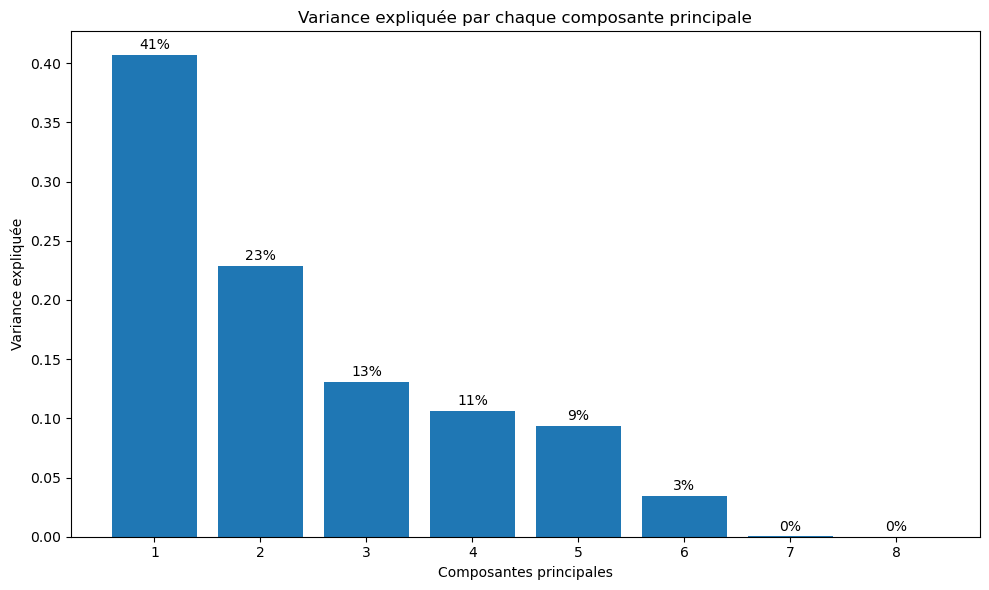

In [ ]:
plt.figure(figsize=(10, 6))
components = range(1, pca.n_components_ + 1)
plt.bar(components, pca.explained_variance_ratio_)
for i, var in zip(components, pca.explained_variance_ratio_):
    plt.text(i, var + 0.005, f'{var:.0%}', ha='center')

plt.title("Variance expliqu√©e par chaque composante principale")
plt.xlabel("Composantes principales")
plt.ylabel("Variance expliqu√©e")
plt.tight_layout()
plt.show()


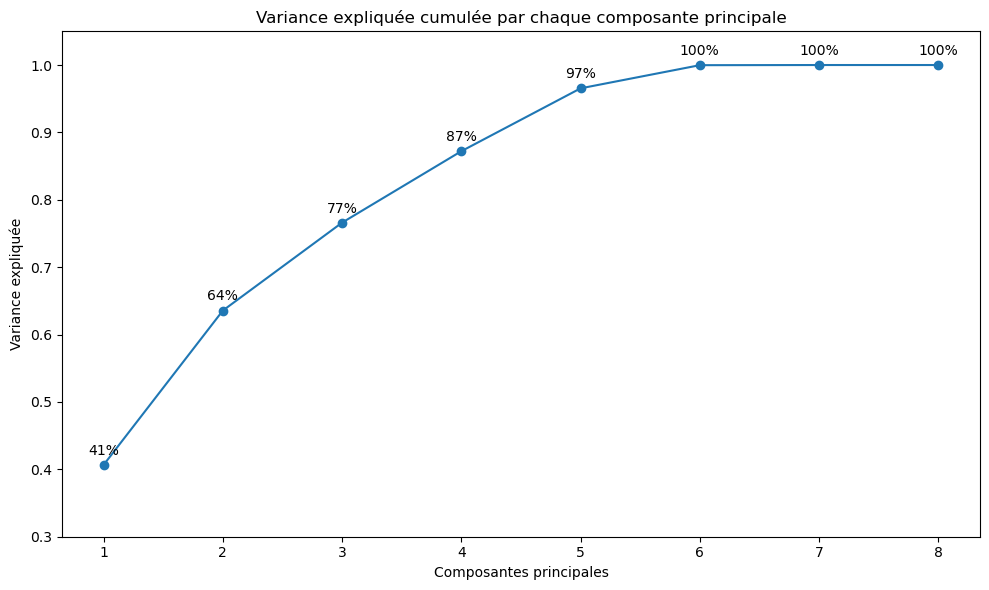

In [ ]:
# Courbe cumulative
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(components, cumulative_variance, '-o')

for i, var in zip(components, cumulative_variance):
    plt.text(i, var + 0.015, f'{var:.0%}', ha='center')

plt.title("Variance expliqu√©e cumul√©e par chaque composante principale")
plt.xlabel("Composantes principales")
plt.ylabel("Variance expliqu√©e")
plt.ylim(0.3, 1.05)
plt.tight_layout()
plt.show()


 Nous continuerons l‚Äôanalyse avec les trois premi√®res composantes principales qui d√©crivent d√©j√† 77% de la
 variabilit√© des donn√©es.

**Cercle de corr√©lation**

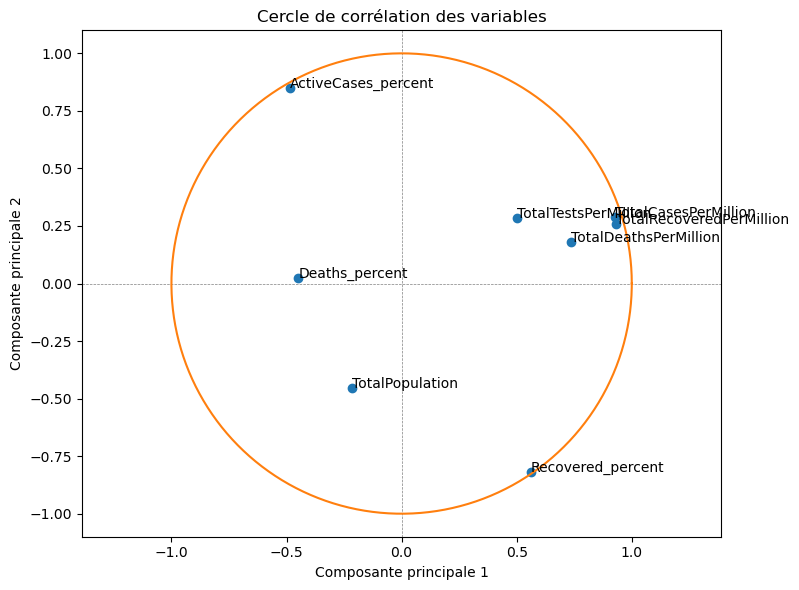

In [ ]:
#Cercle de corr√©lation
def cercle_correlation(axe1=0, axe2=1):
    plt.figure(figsize=(8,6))
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
    racine_lambda_k = np.sqrt(pca.explained_variance_[None, [axe1, axe2]])
    u_kj = pca.components_[[axe1, axe2]].T
    corrs = racine_lambda_k * u_kj
    plt.plot(corrs[:, 0], corrs[:, 1], 'o')
    theta = np.linspace(0, 2*np.pi, 360)
    plt.plot(np.cos(theta), np.sin(theta))
    plt.gca().axis('equal')
    feature_names = getattr(pca, "feature_names_in_", data_for_acp.columns)
    for name, (corr1, corr2) in zip(feature_names, corrs):
        plt.text(corr1, corr2, name, fontsize=10)
cercle_correlation()

plt.title("Cercle de corr√©lation des variables")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.tight_layout()
plt.show()

**Contributions des variables aux composantes principales**

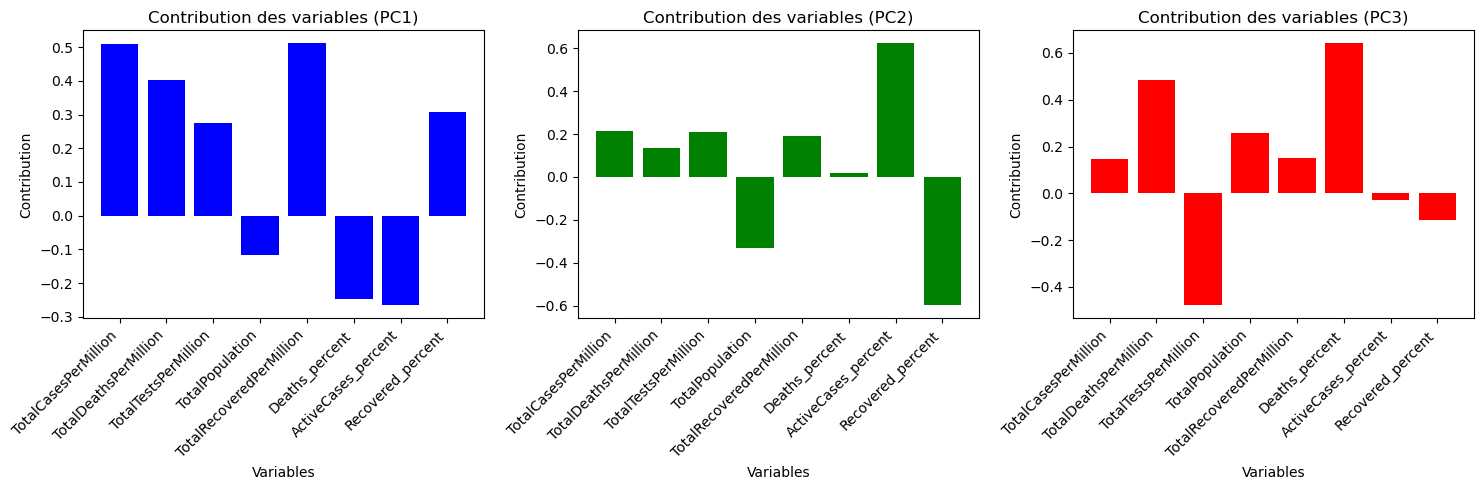

In [ ]:
# Graphique des contributions des variables √† la 1√®re, 2√®me et 3√®me composantes principales
plt.figure(figsize=(15, 5))

# Contribution √† la premi√®re composante principale (PC1)
plt.subplot(1, 3, 1)
plt.bar(data_for_acp.columns, contributions.loc['PC1'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title("Contribution des variables (PC1)")
plt.xlabel("Variables")
plt.ylabel("Contribution")

# Contribution √† la deuxi√®me composante principale (PC2)
plt.subplot(1, 3, 2)
plt.bar(data_for_acp.columns, contributions.loc['PC2'], color='green')
plt.xticks(rotation=45, ha='right')
plt.title("Contribution des variables (PC2)")
plt.xlabel("Variables")
plt.ylabel("Contribution")

# Contribution √† la troisi√®me composante principale (PC3)
plt.subplot(1, 3, 3)
plt.bar(data_for_acp.columns, contributions.loc['PC3'], color='red')
plt.xticks(rotation=45, ha='right')
plt.title("Contribution des variables (PC3)")
plt.xlabel("Variables")
plt.ylabel("Contribution")

plt.tight_layout()
plt.show()

L‚Äôanalyse des contributions des variables est un outil important pour interpr√©ter les axes factoriels issus de l‚ÄôACP.  
Chaque graphique montre l‚Äôimportance relative des variables pour chaque composante principale. Les variables avec une grande valeur absolue (positive ou n√©gative) sont les plus importantes.  

- **PC1**  
Pour la premi√®re composante, on note que les variables **TotalCasesPerMillion**, **TotalDeathsPerMillion**, **TotalTestsPerMillion**, **TotalRecoveredPerMillion** et **RecoveredPercent** ont de fortes contributions positives. **Deaths percent** et **ActiveCases percent** ont une contribution moyenne n√©gative, indiquant qu‚Äôelles sont oppos√©es aux autres variables sur cet axe. Ceci sugg√®re que cette composante est influenc√©e par des indicateurs li√©s au suivi de la pand√©mie tels que le nombre total de cas, de tests r√©alis√©s, de gu√©risons et de d√©c√®s.  

- **PC2**  
Le deuxi√®me axe principal oppose la variable **ActiveCases percent** aux variables **TotalPopulation** et **Recovered percent**. Autrement dit, il oppose la proportion de gu√©risons √† la proportion de cas actifs.  

- **PC3**  
Les variables influentes sur la troisi√®me composante principale (CP) sont **TotalDeathsPerMillion**, **Deaths percent** (contributions positives) et **TotalTestsPerMillion** (contribution n√©gative). Cette composante oppose donc les pays √† forte l√©talit√© √† ceux avec le plus de tests r√©alis√©s.  


### **2.2. Les Kmeans**
On r√©alise maintenant les kmeans sur les trois composantes principales retenues lors de l'ACP.

In [31]:
# L'ACP √† 3 CP
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_normalized)

**M√©thode du coude et du score de silhouette pour choisir le nombre de clusters optimal**

Les kmeans n√©cessitent de fixer √† priori le nombre k de clusters, ce qui n'est pas toujours √©vident. Heureusement, des m√©thodes existent pour faire ce choix : la m√©thode du coude (Elbow Method) et le score de silhouette.

üîª **M√©thode du coude**

La m√©thode du coude consiste √† repr√©senter l‚Äôinertie intra-cluster en fonction du nombre de clusters $K$.

Lorsque $K$ augmente, l‚Äôinertie diminue, car les points sont plus proches de leur centro√Øde. Toutefois, √† partir d‚Äôun certain point, ajouter des clusters n‚Äôapporte plus d'am√©lioration significative.
Le "coude" de la courbe correspond alors √† la valeur de $K$ √† partir de laquelle le gain devient n√©gligeable. Il correspond au nombre optimal de clusters.


üìè **Score de silhouette**

Le score de silhouette √©value la coh√©sion et la s√©paration des clusters obtenus. Il est d√©fini pour chaque observation et varie entre -1 et 1 :

Un score proche de 1 indique que l‚Äôobservation est bien assign√©e √† son cluster tandis qu'un score proche de 0 signifie que l‚Äôobservation est √† cheval entre deux clusters.Un score n√©gatif indique, tout simplement, une mauvaise affectation.

On peut calculer la moyenne des scores de silhouette pour chaque valeur de $K$, et retenir celle qui maximise ce score moyen, garantissant des clusters bien s√©par√©s et coh√©rents.

In [32]:
inertia = []
silhouette_scores = []
range_clusters = range(2, 11)  # Essayer de 2 √† 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)  # Inertie
    silhouette_scores.append(silhouette_score(data_normalized, kmeans.labels_))  # Score de silhouette

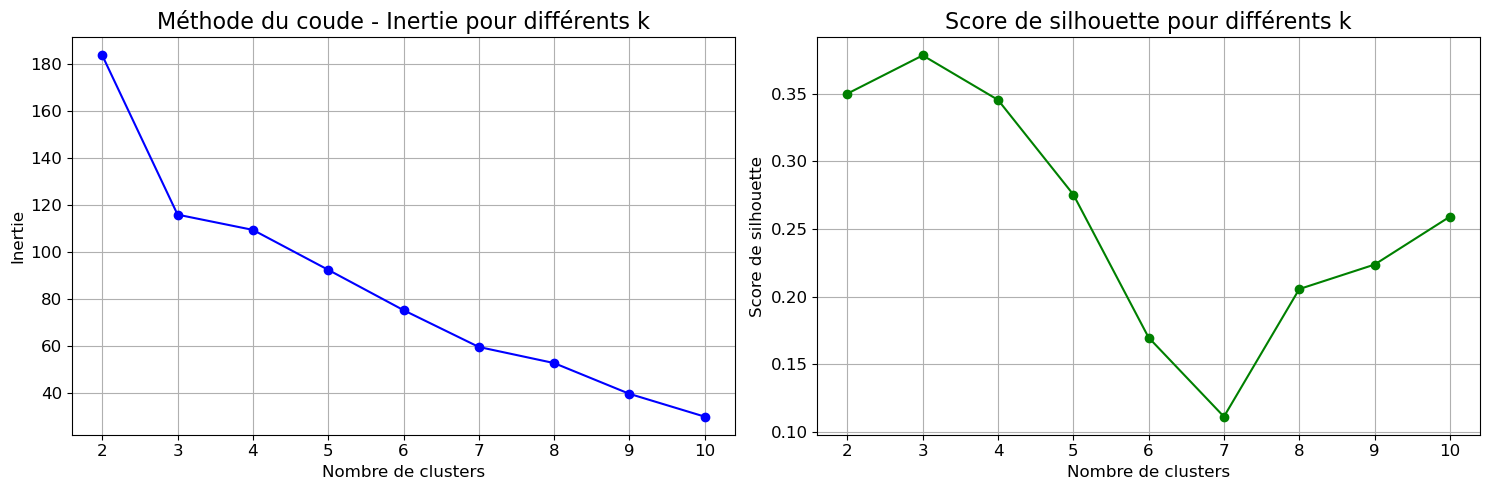

In [ ]:
#La m√©thode du coude (inertie)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range_clusters, inertia, marker='o', linestyle='-', color='b')
plt.title("M√©thode du coude - Inertie pour diff√©rents k", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Nombre de clusters", fontsize=12)
plt.ylabel("Inertie", fontsize=12)
plt.grid(True)

#La m√©thode silouhette
plt.subplot(1, 2, 2)
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title("Score de silhouette pour diff√©rents k", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Nombre de clusters", fontsize=12)
plt.ylabel("Score de silhouette", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

La m√©thode du coude et le graphique du score de silhouette s'accordent sur k = 3 clusters.

**Application des K-means**

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42) 
kmeans.fit(pca_result)

KMeans(n_clusters=3, random_state=42)

**Caract√©ristiques des clusters**

In [35]:
# Ajouter les labels des clusters au DataFrame
pca_result = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
pca_result["Cluster"] = kmeans.fit_predict(pca_result)
pca_result["Country"] = data_mod['Country'].values

In [36]:
print("R√©partition des pays par cluster :")
print(pca_result["Cluster"].value_counts())

R√©partition des pays par cluster :
Cluster
1    29
0    17
2     3
Name: count, dtype: int64


In [37]:
df_clusters = pca_result.groupby('Cluster')['Country'].apply(lambda x: ", ".join(x)).reset_index()
df_clusters.columns = ['Cluster', 'Pays']
df_clusters

Cluster                                               Pays
0        0  UAE, Turkey, Qatar, Palestine, Oman, Mongolia,...
1        1  Vietnam, Uzbekistan, Timor-Leste, Thailand, Ta...
2        2                                 Yemen, Syria, Laos

In [38]:
print("Les 17 pays du premier cluster sont: ")
print(df_clusters.loc[0, "Pays"])

print("\nLes 29 pays du deuxi√®me cluster sont: ")
print(df_clusters.loc[1, "Pays"])

print("\nLes 3 pays du troisi√®me cluster sont: ")
print(df_clusters.loc[2, "Pays"])

Les 17 pays du premier cluster sont: 
UAE, Turkey, Qatar, Palestine, Oman, Mongolia, Maldives, Malaysia, Lebanon, Kuwait, Jordan, Israel, Iran, Georgia, Cyprus, Bahrain, Armenia

Les 29 pays du deuxi√®me cluster sont: 
Vietnam, Uzbekistan, Timor-Leste, Thailand, Tajikistan, Taiwan, Sri Lanka, Singapore, Saudi Arabia, S. Korea, Philippines, Pakistan, Nepal, Myanmar, Macao, Kyrgyzstan, Kazakhstan, Japan, Iraq, Indonesia, India, Hong Kong, China, Cambodia, Brunei, Bhutan, Bangladesh, Azerbaijan, Afghanistan

Les 3 pays du troisi√®me cluster sont: 
Yemen, Syria, Laos


**Comment comprendre ces clusters ?**

Les coordonn√©es moyennes (centro√Ødes) des clusters sur les trois premi√®res composantes de l‚ÄôACP fournissent des informations pour mieux comprendre les caract√©ristiques de chaque groupe de pays.

In [39]:
centroides = pca_result.groupby('Cluster')[['PC1', 'PC2', 'PC3']].mean().reset_index()
centroides = pd.DataFrame(centroides)
centroides = centroides.rename(columns={"PC1": "Centroid_PC1", "PC2": "Centroid_PC2", "PC3": "Centroid_PC3"})
cendroides = centroides.set_index("Cluster")
cendroides

Centroid_PC1  Centroid_PC2  Centroid_PC3
Cluster                                          
0            2.039470      0.539671      0.153684
1           -0.814863     -0.641324     -0.228999
2           -3.679988      3.141335      1.342775

On peut noter : 

- **Cluster 0**

Le centre de gravit√© du Cluster 0, de coordonn√©es (2.04, 0.54, 0.15), indique que ces pays sont caract√©ris√©s par des valeurs √©lev√©es des variables TotalCasesPerMillion, TotalDeathsPerMillion, TotalTestsPerMillion, TotalRecoveredPerMillion, Recovered percent (PC1) et par une proportion mod√©r√©e de cas actifs (PC2).  
*Ce cluster regroupe donc des pays tr√®s expos√©s, avec une proportion mod√©r√©e de cas actifs mais qui parviennent √† bien g√©rer la crise.*

- **Cluster 1** 

Les pays de ce cluster seraient caract√©ris√©s par des valeurs faibles de TotalCasesPerMillion, TotalDeathsPerMillion, TotalTestsPerMillion, TotalRecoveredPerMillion, Recovered percent (PC1), avec plus de cas gu√©ris que de cas actifs et l√©g√®rement plus de tests r√©alis√©s que de d√©c√®s.
*Ce cluster regroupe donc des pays avec une exposition bien suivie et contr√¥l√©e √† la pand√©mie du Covid, avec un bon taux de gu√©rison.* 

- **Cluster 2**

Le Y√©men, la Syrie et le Laos sont des pays avec de tr√®s faibles nombres de cas totaux, de tests r√©alis√©s et de gu√©risons (PC1). Ils r√©alisent peu de tests (PC3), ont beaucoup de cas actifs (PC2) et de d√©c√®s (PC3), et par ricochet peu de cas gu√©ris (PC2).   
*Ces trois pays repr√©sentent donc des pays √† situation critique et n√©cessitent une action rapide.* 


**Visualisation en 3D**

Gr√¢ce √† l'ACP nous pouvons visualiser nos clusters. 

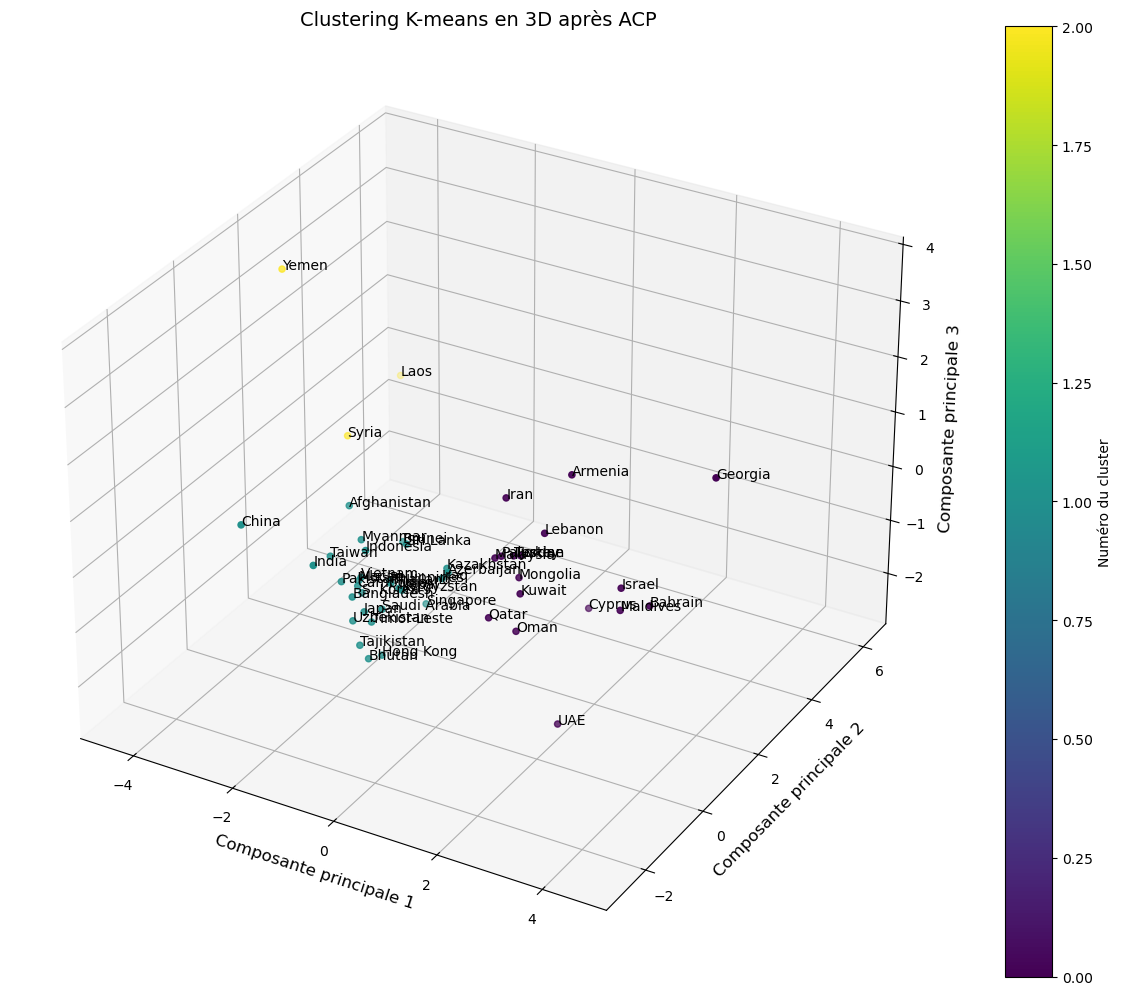

In [ ]:
# Ajouter les labels des clusters au DataFrame
pca_result = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
pca_result["Cluster"] = kmeans.fit_predict(pca_result)
pca_result["Country"] = data_mod['Country'].values

# Visualisation 3D des clusters K-means
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result["PC1"], pca_result["PC2"], pca_result["PC3"], c=pca_result["Cluster"], cmap='viridis')

# L√©gendes
ax.set_xlabel('Composante principale 1', fontsize=12)
ax.set_ylabel('Composante principale 2', fontsize=12)
ax.set_zlabel('Composante principale 3', fontsize=12)
ax.set_title('Clustering K-means en 3D apr√®s ACP', fontsize=14)

# Barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Num√©ro du cluster')

#Affichage des noms des pays
for i in range(len(pca_result)):
    ax.text(pca_result["PC1"].iloc[i], pca_result["PC2"].iloc[i], pca_result["PC3"].iloc[i], pca_result["Country"].iloc[i], size=10)

plt.tight_layout()
plt.show()

## **Conclusion**

Gr√¢ce √† cette √©tude, nous avons pu d√©gager des types de pays asiatiques diff√©rents en termes de gestion de la pand√©mie du Covid-19.  

L'approche robuste **ACP + K-means** s'est r√©v√©l√©e particuli√®rement pertinente. Elle s√©pare :  

- les pays fortement expos√©s, ayant une proportion mod√©r√©e de cas actifs et qui parviennent √† bien g√©rer la crise tels que la G√©orgie, le Qatar, les Maldives, Chypre, la Malaisie, le Liban, ...  
- les pays avec une exposition bien suivie et ma√Ætris√©e de la pand√©mie du Covid tels que l‚ÄôAfghanistan, l‚ÄôArabie saoudite, la Chine, le Vi√™t Nam ...  
- le Y√©men, le Laos et la Syrie, des pays en difficult√©s, ayant besoin d‚Äôattention urgente.  

Ces r√©sultats fournissent un outil d‚Äôaide √† la d√©cision concret pour l‚ÄôOMS, permettant de mieux cibler ses interventions et d‚Äôorienter efficacement les ressources vers les pays qui en ont le plus besoin.
